**Full Name:** Javad Hezareh

**Student Number:** 98101074


# Convolutional Neural Networks
In this notebook, you'll get familiar with the implementation of CNNs by building and training two CNN networks.

## Preparing the Data
For this taks, you're going to use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 is a collection of 32 * 32 images in 10 classes. Each image in CIFAR10 has three channels (RGB). You are going to download and prepare the dataset manually.

In [60]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from sklearn.model_selection import train_test_split
from torchvision.io import read_image

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [61]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [62]:
url = "http://dl.dropboxusercontent.com/s/dywydpafhaamquw/cifar10.zip"
# Download the dataset using Torchvision's  `download_url`
#############################
# Your code goes here (1 point)
download_url(url, root='./')
#############################
!unzip -qq "./cifar10.zip"

100%|██████████| 145997066/145997066 [00:06<00:00, 21795436.29it/s]


Now you are going to implement a custom dataset class for the data you've downloaded. You can implement a custom dataset by inheriting from PyTorch's `Dataset` class. You'll then have to override `__init__`, `__len__`, and `__getitem__` functinos in your custom class. One of the advantages of defining a custom dataset like this is that you have complete control over the data that the dataset returns.

The the dataset you've downloaded has the following structure:
```
cifar10/
    test/
        img_file1.png
        img_file2.png
        ..
        ..
        annotation.csv
    train/
        img_file1.png
        img_file2.png
        ...
        ...
        annotation.csv
```

The `annotation.csv` file in each directory contains a complete list of file names and labels for all the image files in that directory. **Keep in mind that the csv files provided have no header information**.

In [63]:
class CustomCifarDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None):
        """
        `annotation_file`: Path to the csv file with annotations.
        `root_dir`: Directory with all the images.
        `transform`: Transform to be applied.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Read the csv annotation file using pandas' `read_csv` function.
        # (The annotation file consists of n rows. Each row is in the format 
        #    img_file_name, img_label
        #  For example:
        #    airplane_1001, 0
        # )
        #############################
        # Your code goes here (2 points)
        self.df = pd.read_csv(annotations_file, header=None)
        #############################

    def __len__(self):
        # Return the number of data points
        #############################
        # Your code goes here (1 point)
        return len(self.df)
        #############################

    def __getitem__(self, idx):
        """
        idx: index of the data point referenced.
        """
        # Use `idx` to index the annotation file you parsed in `__init__`.
        # Using `read_image`, load the corresponding image from the disk.
        # Normalize the data to be between 0 and 1.
        # Apply transformation(s) to the image and return the transformed 
        # image and its label.
        #############################
        # Your code goes here (7 points)
        image_path = self.df.iloc[idx, 0]
        image = read_image(f'{self.root_dir}/{image_path}')
        image = image / 255
        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(self.df.iloc[idx, 1])

        return image, label
        #############################

In [64]:
test_set = CustomCifarDataset("./cifar10/test/annotation.csv", "./cifar10/test/")
train_set = CustomCifarDataset("./cifar10/train/annotation.csv", "./cifar10/train/")

In [65]:
# Split your training set into train and validation sets (8:2 ratio).
#############################
# Your code goes here (2 points)
val_size = int(0.2 * len(train_set))
train_set, val_set = train_test_split(train_set, test_size=val_size)
#############################

len(train_set), len(val_set), len(test_set)

(40000, 10000, 10000)

In [66]:
# Construct three `DataLoader`s for validation, training, and test sets.
# Use a batch size of 128.
# No shuffling.
#############################
# Your code goes here (5 points)
train_loader = DataLoader(train_set, batch_size=128, shuffle=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)
#############################

In [67]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute model's ouptut
            # Move your data to GPU if it's available
            ##############################
            # Your code goes here (5 points)
            optimizer.zero_grad()
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            ##############################

            # Compute the loss.
            # Also, use L2 regularization to compute the total loss: `loss + lambda * l2`
            # Set the lambda to 0.001.
            ##############################
            # Your code goes here (7 points)
            loss = loss_fn(probs, labels) * len(labels) + 0.001 * torch.tensor([param.norm()**2 for param in model.parameters()]).sum()
            ##############################

            # Do the backprop step.
            ##############################
            # Your code goes here (2 points)
            loss.backward()
            optimizer.step()
            ##############################
            
            loss_train += loss.item()

        validation_loss = validate(model, val_loader, loss_fn)
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, loss_train / len(train_loader), validation_loss))


In [68]:
def validate(model, val_loader, loss_fn):
    with torch.no_grad():
        val_loss = 0.0
        for imgs, labels in val_loader:
            # Compute the loss
            ##############################
            # Your code goes here (9 points)
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            loss = loss_fn(probs, labels)
            ##############################
            val_loss += loss.item()

    return val_loss / len(val_loader)

**Answer the following questions (5 points):**
- What is `torch.no_grad()` and when is it used?

    This function will disable the autograd feature of the PyTorch package. This means during calculation pytorch will not calculate and save gradient w.r.t parameters. This leads to faster calculation. When we don't need the gradients we can use this function, such as while we are validating or testing our model.

- What do the instructions `model.eval()` and `model.train()` do?

    These functions change the mode of the model. As their name suggests, `model.train()` will enable the training mode of the model, and `model.eval()` will enable the testing mode. The model mode is crucial when it contains layers such as Dropout or BatchNormalization that behave differently during training and testing time. Using these functions tell these layers how to behave.

In [69]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
        # Compute the predicted class and update 
        # `total` and `correct` accordingly
        ##############################  
        # Your code goes here (9 points)
            imgs = imgs.to(device)
            labels = labels.to(device)

            probs = model(imgs)
            predicted = torch.argmax(probs, dim=1)
            correct += (predicted == labels).sum().item()
            total += len(labels)
        ##############################

        return correct / total

## Creating the Model
Now you're going to build the CNN model. The overall architecture of the model you are going to implement is depicted in the following picture (All of the max poolings used have a stride of 2*2):

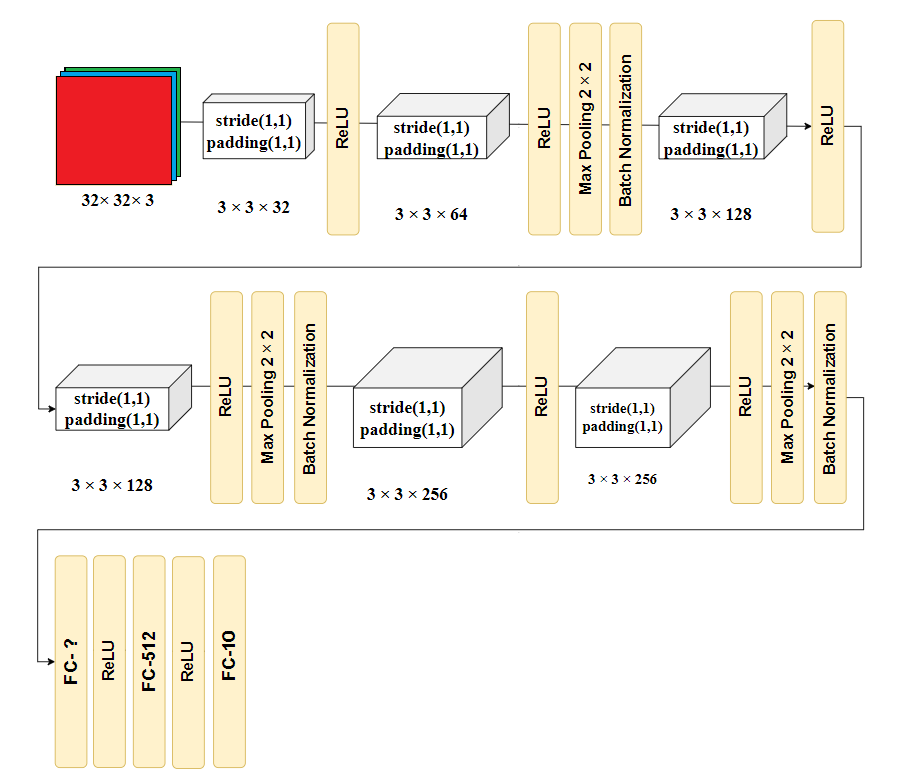

In [70]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        """
        `in_channels`: Number of channels for input instances
        `out_dim`    : The network's output dimensions
        """
        super().__init__()
        self.relu = nn.ReLU()            # Apply for all the layers (except the last one)
        self.maxpool = nn.MaxPool2d(2,2) # Apply for conv2, conv4, and conv6
        
        self.bn1 = nn.BatchNorm2d(64) # Apply for conv2
        self.bn2 = nn.BatchNorm2d(128) # Apply for conv4
        self.bn3 = nn.BatchNorm2d(256) # Apply for conv6
        
        self.conv1 = self.conv2 = self.conv3 = self.conv4 = self.conv5 = self.conv6 = None
        self.fc1 = self.fc2 = self.fc3 = None

        
        # Create five 2D convolutional layers (conv1 through conv6)
        # Set the padding and stride to 1 for all the layers.
        # Use 3*3 kernels.
        ##############################
        # Your code goes here (10 points)
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        ##############################

        self.flatten = nn.Flatten()
        
        # According to the output dimensions of `conv6` and the `in_features` value for fc2,
        # set `in_features` and `out_features` for fc1 to proper values. 
        ##############################
        # your code goes here (5 points)
        self.fc1 = nn.Linear(4*4*256, 1024)
        #############################
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_dim)
        
    def forward(self, x):
        # Move x thorugh the network and return the output
        # according to the architecture.
        ##############################
        # Your code goes here (10 points)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn2(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.fc3(x)
        ##############################
        return out

In [71]:
model = SimpleCNN(3, 10).to(device=device)

In [72]:
# Use Adam optimizer with a learning rate of 0.001 as the optimizer.
# Use CrossEntropy as loss function.
##############################
# Your code goes here (5 points)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
##############################
train(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

Epoch 1, Training loss 175.10022764845777, Validation loss 0.9813609417480759
Epoch 2, Training loss 107.18869079492343, Validation loss 0.7879121250744108
Epoch 3, Training loss 82.95078197150184, Validation loss 0.7366706789294376
Epoch 4, Training loss 66.7717392345587, Validation loss 0.7404872703401348
Epoch 5, Training loss 56.24373871678362, Validation loss 0.8028836027730869
Epoch 6, Training loss 47.601305824499164, Validation loss 0.859817537325847
Epoch 7, Training loss 40.40378863666766, Validation loss 0.9430385390414467
Epoch 8, Training loss 34.031143030038656, Validation loss 0.9978499691697615
Epoch 9, Training loss 29.217847098938574, Validation loss 1.0802920041959496
Epoch 10, Training loss 26.40074870685419, Validation loss 1.0924562174543928


In [73]:
test(model, test_loader)

0.78

## Visualizing Feature Maps

The feature maps, also known as activation maps, record what happens when the filters are applied to an input.


In this section, you're going to visualize feature maps for a random input image for layers `conv1` through `conv6`. 

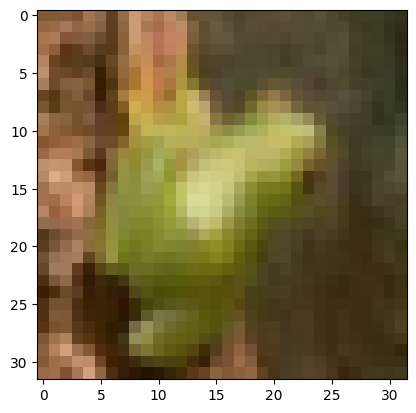

In [37]:
import random
img = train_set[random.randint(0, len(train_set))][0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [38]:
conv_layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6]

# Pass `img` thorough the layers and save the results for each layer in `output`.
##############################
# Your code goes here (5 points)
outputs = []
out = img
with torch.no_grad():
    for layer in conv_layers:
        out = out.to(device)
        out = layer(out)
        outputs.append(out)
##############################
len(outputs)

6

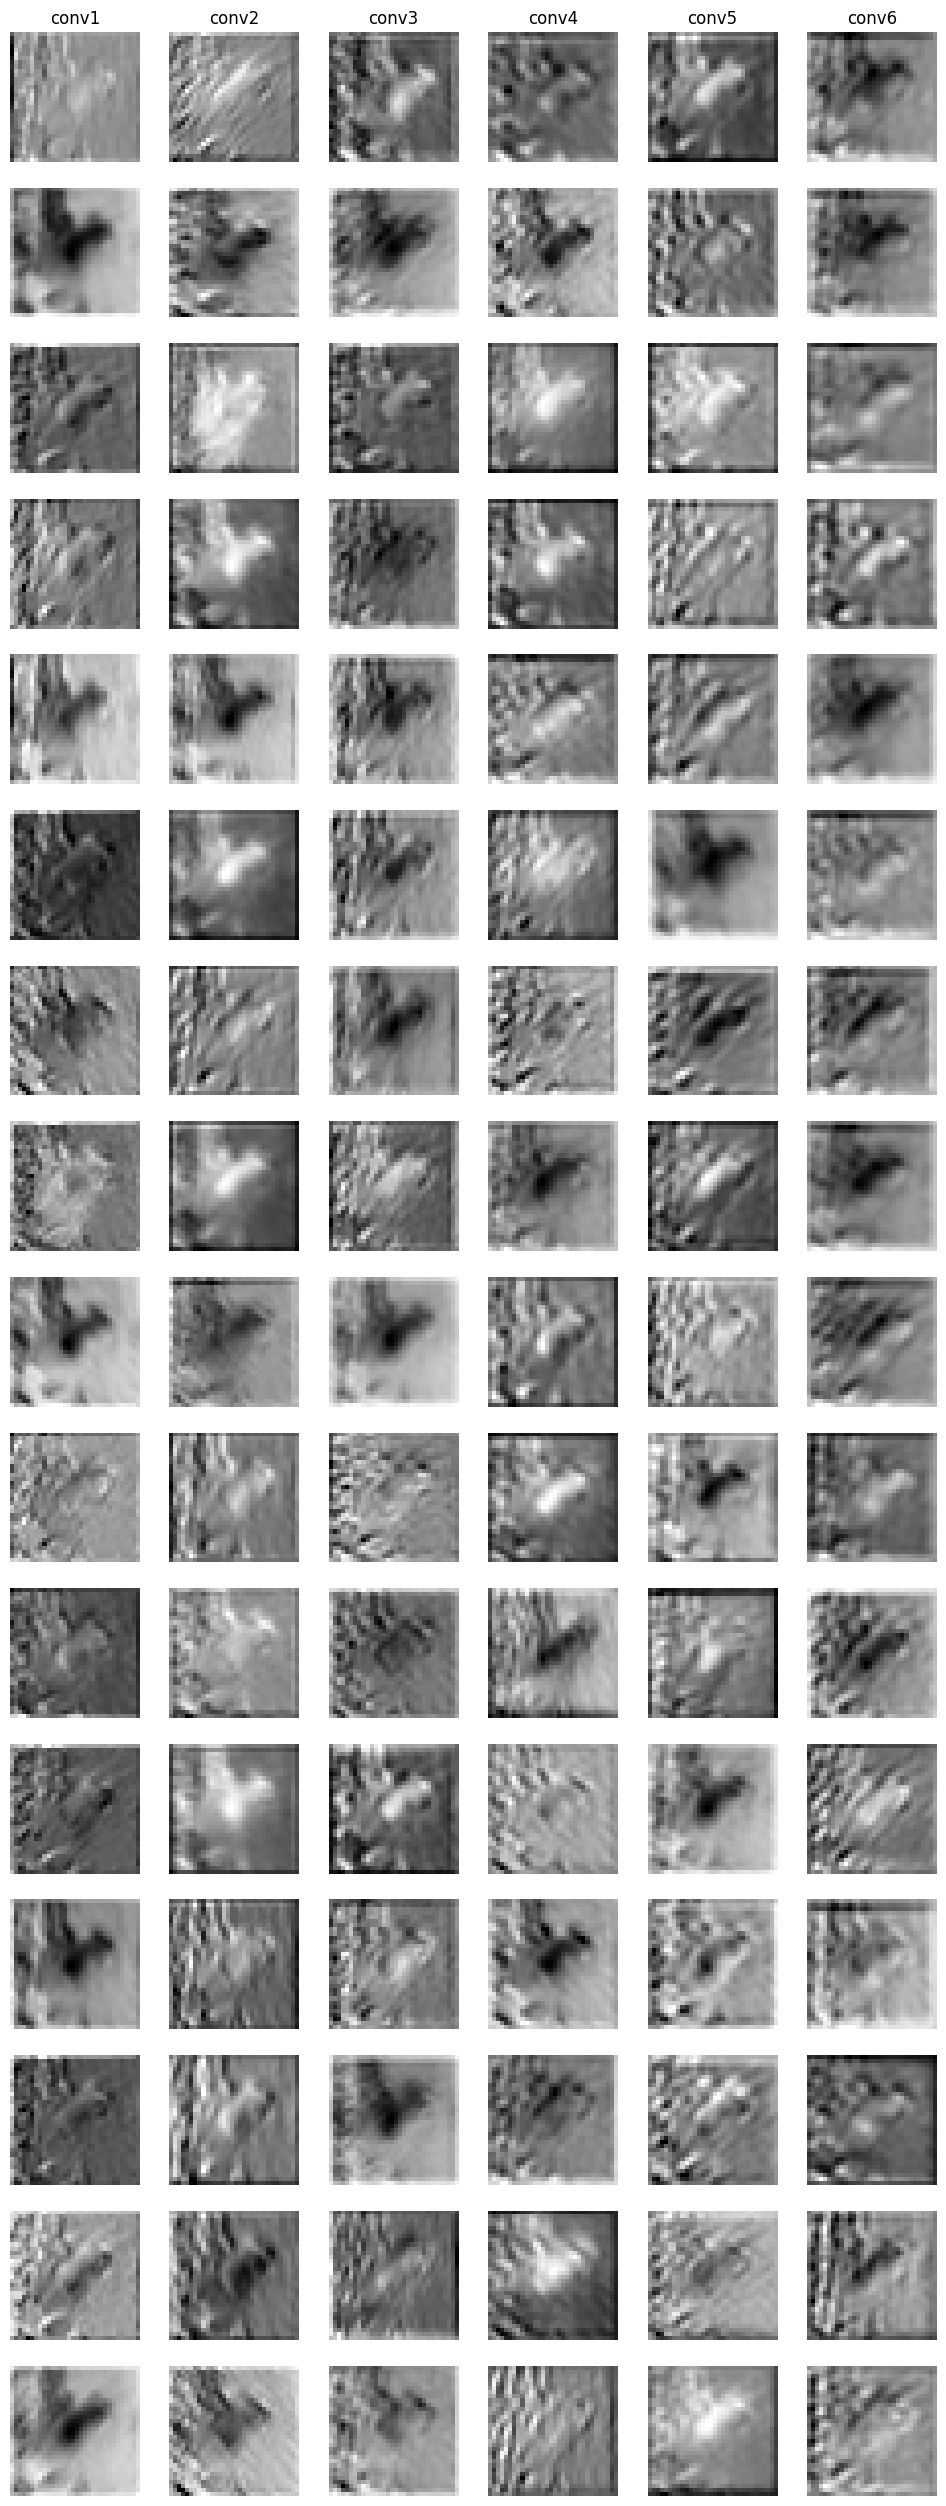

In [44]:
# Visualize the output for the first 16 filters of each layer.
##############################
# Your code goes here (5 points)
fig, axis = plt.subplots(16, 6, figsize=(2*6, 2*16))

for i, out in enumerate(outputs):
    samples = out[0:16, :, :]
    for j in range(16):
        vmin = torch.min(samples[j, :, :])
        vmax = torch.max(samples[j, :, :])
        axis[j, i].imshow(samples[j, :, :].cpu(), cmap='gray', vmin=vmin, vmax=vmax)
        axis[j, i].axis('off')
        axis[0, i].set_title(f'conv{i+1}')
        axis[j, 0].set_ylabel(f'map{j}')
##############################

**Answer the following question (5 points):**
- Which one of the feature maps you visualized do you find helpful for the task? Which ones you don't find helpful?

    As we can see most of the maps focus on the main element of the picture which is the frog body. These maps can help the model to figure out the class of the input. In some maps, the model has focused on the background which might not be helpful to predict the label.